In [330]:
#-------Plot Chandra photometry data-------#
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from astropy.table import Table
import scipy, pylab
from scipy.integrate import trapz, simps, quad
import math
import astropy
import pyregion
from matplotlib.lines import Line2D
from astropy.io import fits
import matplotlib.cm as cmx
import matplotlib.colors as colors

wittmann = Table.read('wittmann-2017.csv')
netcounts11714 = Table.read('netcounts/11714_netcounts.csv')
netcounts11715 = Table.read('netcounts/11715_netcounts.csv')
netcounts11713 = Table.read('netcounts/11713_netcounts.csv')
songcounts = Table.read('netcounts/song_netcounts.csv')

netcounts1 = np.append(netcounts11713['net_counts'], netcounts11714['net_counts']) 
netcounts1 = np.append(netcounts1, netcounts11715['net_counts'])  
netcounts1 = np.append(netcounts1, songcounts['net_counts'])                                    # all netcount info

yupp1 = np.append(netcounts11713['upper_err'], netcounts11714['upper_err'])   				  # Set upper and lower limits from csv files
yupp1 = np.append(yupp1, netcounts11715['upper_err'])
yupp1 = np.append(yupp1, songcounts['upper_err'])

ylow = np.append(netcounts11713['lower_err'], netcounts11714['lower_err'])
ylow = np.append(ylow, netcounts11715['lower_err'])
ylow1 = np.append(ylow, songcounts['lower_err'])
           
ra1 = np.append(netcounts11713['ra'], netcounts11714['ra'])
ra1 = np.append(ra1, netcounts11715['ra'])
ra1 = np.append(ra1, songcounts['ra'])

dec1 = np.append(netcounts11713['dec'], netcounts11714['dec'])
dec1 = np.append(dec1, netcounts11715['dec'])
dec1 = np.append(dec1, songcounts['dec'])

idarray = np.append(netcounts11713['chandra_ID'], netcounts11714['chandra_ID'])
idarray = np.append(idarray, netcounts11715['chandra_ID'])
idarray = np.append(idarray, (songcounts['chandra_ID']))

#-----define a distance function to get distances in degrees between two objects given their ra,dec-----
def degreedist(ra1, dec1, ra2, dec2):
    ra2 = math.radians(ra2)
    dec2 = math.radians(dec2)
    ra1 = math.radians(ra1)
    dec1 = math.radians(dec1)
    cosdist = math.sin(dec1)*math.sin(dec2) + (math.cos(dec1)*math.cos(dec2)*math.cos(ra1 - ra2))
    return math.degrees(math.acos(cosdist))

#-----filter out objects too far away from the target ra, dec of each Chandra Observation's fits file-----
#-----create an array of the indexes that fall within the desired distances
maxdist = 0.116667 # degrees
#maxdist = 0.2
#maxdist = 2
indxs = []
def fits_file(imagenum):  # takes each file's number and returns a string fits filename
    if int(imagenum) < 1000:
        return 'FITSfiles/acisf00%s_repro_evt2.fits' %imagenum
    if int(imagenum) < 10000:
        return 'FITSfiles/acisf0%s_repro_evt2.fits' %imagenum
    else:
        return 'FITSfiles/acisf%s_repro_evt2.fits' %imagenum

print(len(idarray))

68


In [331]:
indxs = []
exptime = []
for id in range(len(ra1)):
    fname = fits_file(idarray[id])
    hdulist = fits.open(fname)
    hduheader = hdulist[1].header
    ra_targ = hduheader['RA_TARG']
    dec_targ = hduheader['DEC_TARG']
    exp_time = hduheader['EXPOSURE']
    
    dist = degreedist(ra1[id], dec1[id], ra_targ, dec_targ)
    if dist < maxdist:
        indxs.append(id)
        exptime.append(exp_time)

print(indxs)

[4, 5, 8, 9, 10, 11, 14, 15, 18, 19, 20, 21, 22, 23, 24, 25, 36, 37, 38, 39, 42, 43, 48, 49, 56, 57, 58, 59, 60, 61, 64, 65]


In [332]:
# select attributes from objects within desired threshold
ra = np.zeros(len(indxs))
dec = np.zeros(len(indxs))
yupp = np.zeros(len(indxs))
ylow = np.zeros(len(indxs))
netrate = np.zeros(len(indxs))

for i in range(len(indxs)):
    netrate[i] = (netcounts1[indxs[i]] / exptime[i]) * 1000
    yupp[i] = (yupp1[indxs[i]] / exptime[i]) * 1000
    ylow[i] = (ylow1[indxs[i]] / exptime[i]) * 1000
    ra[i] = ra1[indxs[i]]
    dec[i] = dec1[indxs[i]]
    
netrate_300 = netrate[0::2]     # separate by energy level (300kev-2000kev, 2000kev-7000kev)
netrate_2000 = netrate[1::2]
yupp_300 = yupp[0::2]
yupp_2000 = yupp[1::2]
ylow_300 = ylow[0::2]
ylow_2000 = ylow[1::2]
    
#-----compute distances from NGC1275-----
ra_NGC1275 = 49.95041666
dec_NGC1275 = 41.51138889
distarray = np.zeros(len(ra))
for i in range(len(ra)):
    distarray[i] = degreedist(ra[i], dec[i], ra_NGC1275, dec_NGC1275)

distarray = distarray[0::2]

len(distarray)
len(ra)


32

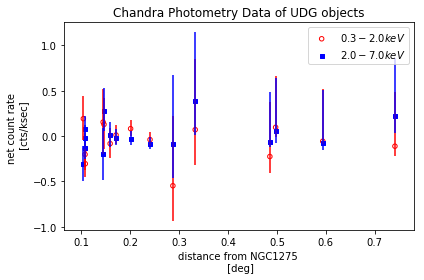

In [333]:
#------make the plot-----
ax1 = pylab.subplot(111)

ax1.scatter(distarray, netrate_300, s=20, facecolors='none', edgecolors='r', label='$0.3-2.0 keV$')
ax1.scatter(distarray, netrate_2000, s=20, c = 'b', marker = "s", label = '$2.0-7.0 keV$')

ax1.errorbar(distarray, netrate_300, yerr=(ylow_300, yupp_300), linestyle='none', ecolor='r')
ax1.errorbar(distarray, netrate_2000, yerr=(ylow_2000, yupp_2000), linestyle='none', ecolor='b')


#pylab.ylim([40.8, 42.0])
#pylab.xlim([])
plt.title('Chandra Photometry Data of UDG objects')
plt.xlabel('distance from NGC1275 \n [deg]')
plt.ylabel('net count rate \n [cts/ksec]')
#plt.ylim(-0.002, 0.002)
plt.legend(loc='best')
plt.tight_layout()

plt.show()

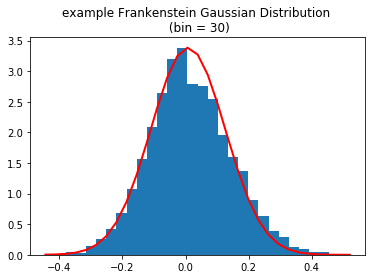

In [334]:
from random import *

#fupp = np.exp(-((y-u)/sigup)**2/2) / sigup / np.sqrt(2 * np.pi)   
#flow = np.exp(-((y-u)/siglo)**2/ 2) / siglo / np.sqrt(2 * np.pi)

# define a gaussian type function
def gauss(x, mu, sigma):
    return (np.exp(-((x-mu)/sigma)**2/ 2)) / (sigma*np.sqrt(2 * np.pi))

#def error_distribution(mu, sigup, siglo):
s = []
s = np.asarray(s)
for i in range(10000):           
    rand = uniform(-1, 1) # generate random number between -1 and 1 and use as a coin flip
    if rand == 0:         # if zero, flip again
        rand = uniform(-1, 1) 
    if rand < 0:          # if tails, choose a number from the lower 
        value = -(abs(np.random.normal(0, siglo, 1)))
        
    else:                 # if heads, use upper error bound, sigup
        value = abs(np.random.normal(0, sigup, 1))
    s = np.append(s, mu+value)
        



count, bins, ignored = plt.hist(s, 30, normed=True)
plt.plot(bins, 1/(siglo * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * siglo**2) ),
          linewidth=2, color='r')
plt.title('example Frankenstein Gaussian Distribution \n (bin = 30)')
plt.show()


In [335]:
def f_model(x, a, b):
    # pars is an array [a,b] to fit our function's form.
    # function form: f = a/x^2 + b
    return a*(1/(np.array(x))**2) + b

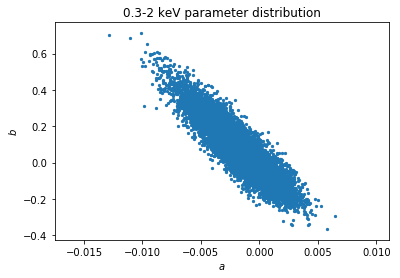

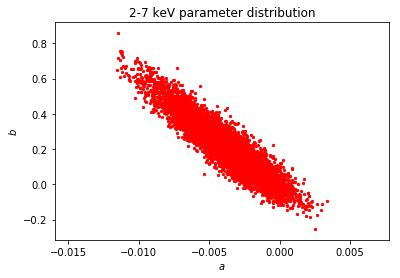

In [361]:
from scipy.optimize import curve_fit

ntrials = 10000       # number of times we want to sample data within th error bands and fit model parameters

x_data = distarray
pararray = []
pararray1 = np.asarray(pararray)
y_data = []
y_data = np.zeros(len(distarray))

for i in range(ntrials):
    for i in range(len(distarray)):
        sigup = yupp_300[i]
        siglo = ylow_300[i]
        mu = netrate_300[i]
        
        rand = uniform(-1, 1) # generate random number between -1 and 1 and use as a coin flip
        if rand == 0:         # if zero, flip again
            rand = uniform(-1, 1) 
        if rand < 0:          # if tails, choose a number from the lower 
            y_data[i] = mu - (abs(np.random.normal(0, siglo, 1)))   
        else:                 # if heads, use upper error bound, sigup
            y_data[i] = mu + abs(np.random.normal(0, sigup, 1))


    popt, pcov = curve_fit(f_model, x_data, y_data)
    pararray1 = np.append(pararray1, popt)
    
pararray2 = []
pararray2 = np.asarray(pararray2)

for i in range(ntrials):
    for i in range(len(distarray)):
        sigup = yupp_2000[i]
        siglo = ylow_2000[i]
        mu = netrate_2000[i]
        
        rand = uniform(-1, 1) # generate random number between -1 and 1 and use as a coin flip
        if rand == 0:         # if zero, flip again
            rand = uniform(-1, 1) 
        if rand < 0:          # if tails, choose a number from the lower 
            y_data[i] = mu - (abs(np.random.normal(0, siglo, 1)))   
        else:                 # if heads, use upper error bound, sigup
            y_data[i] = mu + abs(np.random.normal(0, sigup, 1))


    popt, pcov = curve_fit(f_model, x_data, y_data)
    pararray2 = np.append(pararray2, popt)


    

#plt.plot(x_data, f_model(x_data, *popt), 'r-', label='fit')
fig1 = plt.figure()                # create common figure
fig2 = plt.figure()
ax1 = fig1.add_subplot(111)

a_array300 = pararray1[0::2]
b_array300 = pararray1[1::2]

par300 = a_array300, b_array300
pars300 = np.stack(par300, axis=1)                # stack the a and b parameters for easy access

pars300 = pars300[1000:]

ax1.scatter(a_array300, b_array300, s=20, marker='.')
ax1.set_xlabel('$a$')
ax1.set_ylabel('$b$')
ax1.set_title("0.3-2 keV parameter distribution")



a_array2000 = pararray2[0::2]
a_array2000 = a_array2000[1000:]

b_array2000 = pararray2[1::2]
b_array2000 = b_array2000[1000:]

par2000 = a_array2000, b_array2000
pars2000 = np.stack(par2000, axis=1)

pars2000 = pars2000[1000:]

ax2 = fig2.add_subplot(111)
ax2.scatter(a_array2000, b_array2000, s=20, color='r', marker='.')
ax2.set_xlabel('$a$')
ax2.set_ylabel('$b$')
ax2.set_title("2-7 keV parameter distribution")
plt.show()

In [441]:
from IPython import display

low,med,hi = np.percentile(pars300, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str1 = ""
for i,name in enumerate(['a_.3', 'b_.3']):
        fmt_str = '{name}={val:.4f}^{{+{plus:.4f}}}_{{-{minus:.4f}}}'
        disp_str1 += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
        disp_str1 += r'\quad '

disp_str1 = "${}$".format(disp_str1)
display.Latex(data=disp_str1)



<IPython.core.display.Latex object>

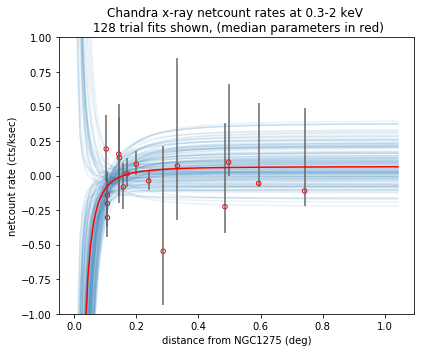

In [444]:
plt.figure(figsize=(6,5))

plt.scatter(distarray, netrate_300, s=20, facecolors='none', edgecolors='r', label='$0.3-2.0 keV$')
plt.errorbar(distarray, netrate_300, yerr=(ylow_300, yupp_300), linestyle='none', ecolor='#666666')


x_grid = np.linspace(distarray.min()-0.1, distarray.max()+0.3, 128)
for pars in range(len(a_array300[:128])):
    plt.plot(x_grid, f_model(x_grid, a_array300[pars], b_array300[pars]), 
             marker='', linestyle='-', color='#3182bd', alpha=0.1, zorder=-10)

plt.plot(x_grid, f_model(x_grid, med[0], med[1]), color='r')
plt.ylim(-1, 1)    
plt.xlabel('distance from NGC1275 (deg)')
plt.ylabel('netcount rate (cts/ksec)')
plt.title('Chandra x-ray netcount rates at 0.3-2 keV \n 128 trial fits shown, (median parameters in red)')
plt.tight_layout()
plt.show()

In [465]:
#separate objects (Mostly Song's UDGs) out that 
#are further than 0.2 degrees from the center of Perseus
indxs2 = indxs[0::2]    # only want every other index (doubles in spreadsheet)
sumdist = 0.0
count = 0
for i in range(len(distarray)):
    if distarray[i] > 0.2:
        print(idarray[indxs2[i]])
        sumdist += distarray[i]
        count += 1
avedist_song = sumdist/count  # find the average distance of these far-out objects
print(avedist_song)

11713
11713
17262
17285
17285
17268
17271
17274
0.422373484422


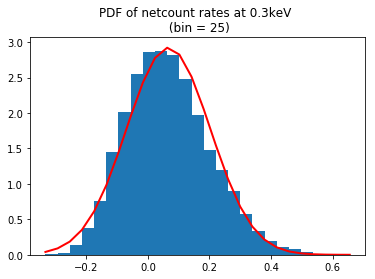

In [466]:
# Finding +/-3 sigma for our fits of Song/far-out Wittmann UDGs
# (at 0.3 keV)
cts = np.zeros(len(a_array300))
for i in range(len(cts)):    # compute counts according to every parameter fit
                             # at the average distance
    cts[i] = f_model(avedist_song, a_array300[i], b_array300[i])
    
# create an approximate Gaussian to display with histogram
mu = np.sum(cts) / len(cts)
sigma = np.std(cts)

counts, bins, ignored = plt.hist(cts, 25, normed=True) # make histogram
plt.plot(bins, 1/(sigma * np.sqrt(2 * np.pi)) *
                np.exp( - (bins - mu)**2 / (2 * sigma**2) ),
          linewidth=2, color='r')                      # plot our histogram

plt.title('PDF of netcount rates at 0.3keV \n (bin = 25)')
plt.show()


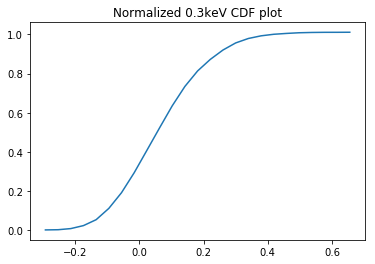

-3sigma =  -0.331357452939
 median =   0.161481531874
+3sigma =   0.654320516687


In [467]:
# create a cumulative distribution function of our histogram
cdf = np.cumsum(counts)
plt.plot(bins[1:], cdf/25.)
plt.title("Normalized 0.3keV CDF plot")
plt.show()
bins
# find our upper and lower 3-sigma bounds
low,med,hi = np.percentile(bins, [0.15, 50, 99.85], axis=0)
print("-3sigma = ", low)
print(" median =  ", med)
print("+3sigma =  ", hi)

In [365]:
low,med1,hi = np.percentile(pars2000, [16, 50, 84], axis=0)
upper, lower = hi-med1, med1-low

disp_str = ""
for i,name in enumerate(['a_2', 'b_2']):
        fmt_str = '{name}={val:.4f}^{{+{plus:.4f}}}_{{-{minus:.4f}}}'
        disp_str += fmt_str.format(name=name, val=med1[i], plus=upper[i], minus=lower[i])
        disp_str += r'\quad '

disp_str = "${}$".format(disp_str)
display.Latex(data= disp_str)

<IPython.core.display.Latex object>

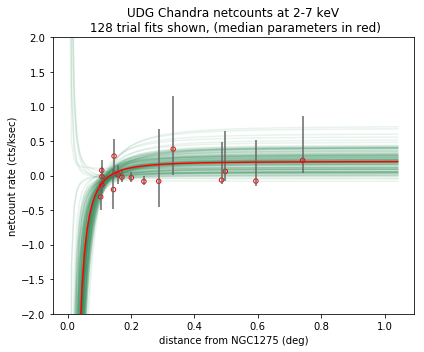

In [366]:
plt.figure(figsize=(6,5))

plt.scatter(distarray, netrate_2000, s=20, facecolors='none', edgecolors='r', label='$0.3-2.0 keV$')
plt.errorbar(distarray, netrate_2000, yerr=(ylow_2000, yupp_2000), linestyle='none', ecolor='#666666')


x_grid = np.linspace(distarray.min()-0.1, distarray.max()+0.3, 128)
for pars in range(len(a_array2000[:128])):
    plt.plot(x_grid, f_model(x_grid, a_array2000[pars], b_array2000[pars]), 
             marker='', linestyle='-', color='#2e8b57', alpha=0.1, zorder=-10)
plt.plot(x_grid, f_model(x_grid, med1[0], med1[1]), color='r')
plt.ylim(-2, 2)    
plt.xlabel('distance from NGC1275 (deg)')
plt.ylabel('netcount rate (cts/ksec)')
plt.title('UDG Chandra netcounts at 2-7 keV\n 128 trial fits shown, (median parameters in red)')
plt.tight_layout()
plt.show()

In [358]:
low,med1,hi = np.percentile(pars2000, [.2, 50, .2], axis=0)
upper, lower = hi-med1, med1-low

disp_str = ""
for i,name in enumerate(['a_2', 'b_2']):
        fmt_str = '{name}={val:.4f}^{{+{plus:.4f}}}_{{-{minus:.4f}}}'
        disp_str += fmt_str.format(name=name, val=med1[i], plus=upper[i], minus=lower[i])
        disp_str += r'\quad '

print(upper[1])
print(lower[1])
disp_str = "${}$".format(disp_str)
display.Latex(data= disp_str)

-0.268530034085
0.268530034085


<IPython.core.display.Latex object>

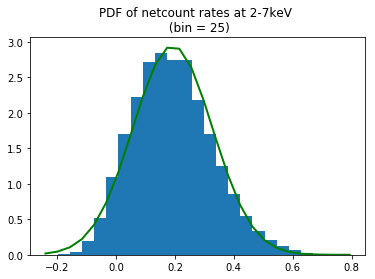

In [476]:
# Finding +/-3 sigma for our fits of Song/far-out Wittmann UDGs
# (at 2-7 keV)
cts2 = np.zeros(len(a_array2000))
for i in range(len(cts2)):    # compute counts according to every parameter fit
                             # at the average distance
    cts2[i] = f_model(avedist_song, a_array2000[i], b_array2000[i])
    
# create an approximate Gaussian to display with histogram
mu2 = np.sum(cts2) / len(cts2)
sigma2 = np.std(cts2)

counts2, bins2, ignored2 = plt.hist(cts2, 25, normed=True) # make histogram
plt.plot(bins2, 1/(sigma2 * np.sqrt(2 * np.pi)) *
                np.exp( - (bins2 - mu2)**2 / (2 * sigma2**2) ),
          linewidth=2, color='g')                      # plot our histogram

plt.title('PDF of netcount rates at 2-7keV \n (bin = 25)')
plt.show()


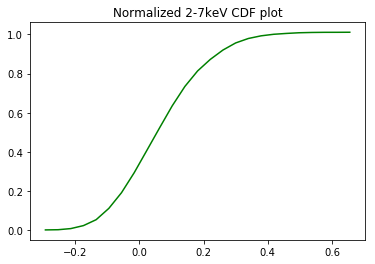

-3sigma =  -0.331357452939
 median =   0.161481531874
+3sigma =   0.654320516687


In [474]:
# create a cumulative distribution function of our histogram
cdf = np.cumsum(counts)
plt.plot(bins[1:], cdf/25., color='g')
plt.title("Normalized 2-7keV CDF plot")
plt.show()
bins
# find our upper and lower 3-sigma bounds
low,med,hi = np.percentile(bins, [0.15, 50, 99.85], axis=0)
print("-3sigma = ", low)
print(" median =  ", med)
print("+3sigma =  ", hi)

In [360]:
print(f_model(0.4, upper[0], upper[1]))

print(f_model(0.4, med1[0], med1[1])) 

print(f_model(0.4, lower[0], lower[1]))

-0.299498947657
0.188861104777
0.299498947657


In [438]:
# limit ----> +infinity of f_model
print(f_model(10000, med1[0], med1[1]))

0.205261763416


In [138]:
def decay_model(x, a, b):
    #pars = np.asarray(pars)
    # pars is an array [a,b] to fit our function's form.
    # function form: f = a/x^2 + b
    return a*(-1/((np.array(x))**2)) + b

In [139]:

vGuess = [-1.0,2.0]
ntrials = 4000

aFitPars = np.array([])

In [140]:
aFitSameTimes = np.array([])
x_data = distarray
y_data = np.zeros(len(distarray))
for i in range(4000):
    
    
    for i in range(len(distarray)):
        sigup = yupp_300[i]
        siglo = ylow_300[i]
        mu = netcounts_300[i]
        
        rand = uniform(-1, 1) # generate random number between -1 and 1 and use as a coin flip
        if rand == 0:         # if zero, flip again
            rand = uniform(-1, 1) 
        if rand < 0:          # if tails, choose a number from the lower 
            y_data[i] = mu - (abs(np.random.normal(0, siglo, 1)))   
        else:                 # if heads, use upper error bound, sigup
            y_data[i] = mu + abs(np.random.normal(0, sigup, 1))

    
    try:
        vTrial,aCova = curve_fit(decay_model, x_data, y_data, vGuess)
    except:
        dumdum = 1
        continue
        
    # stack the ith trial onto the running sample:
    if np.size(aFitSameTimes) < 1:
        aFitSameTimes=np.copy(vTrial)
    else:
        aFitSameTimes = np.vstack((aFitSameTimes, vTrial))


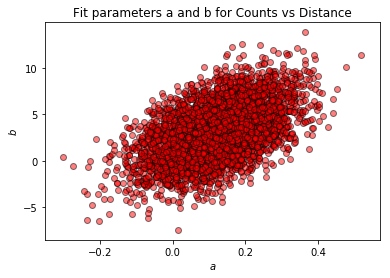

In [142]:
plt.scatter(aFitSameTimes[:,0], aFitSameTimes[:,1],c='r', s=36, edgecolor='k', alpha=0.5)
plt.xlabel('$a$')
plt.ylabel('$b$')
plt.title('Fit parameters a and b for Counts vs Distance')
plt.show()

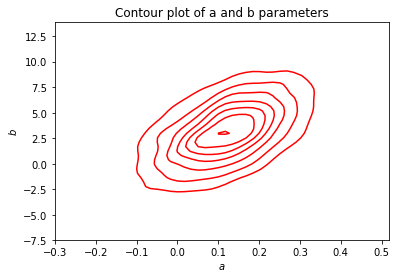

In [144]:
from scipy.stats import kde
xS,yS=aFitSameTimes.T
kS = kde.gaussian_kde(aFitSameTimes.T)
nbins=50
xiS, yiS = np.mgrid[xS.min():xS.max():nbins*1j, yS.min():yS.max():nbins*1j]
ziS = kS(np.vstack([xiS.flatten(), yiS.flatten()]))

plt.contour(xiS, yiS, ziS.reshape(xiS.shape), colors='r', zorder=15, alpha=1.0)


plt.title('Contour plot of a and b parameters')

plt.xlabel('$a$')
plt.ylabel('$b$')
plt.show()

In [145]:
pars300 = aFitSameTimes
low,med,hi = np.percentile(pars300, [16, 50, 84], axis=0)
upper, lower = hi-med, med-low

disp_str = ""
for i,name in enumerate(['a_.3', 'b_.3']):
        fmt_str = '{name}={val:.2f}^{{+{plus:.2f}}}_{{-{minus:.2f}}}'
        disp_str += fmt_str.format(name=name, val=med[i], plus=upper[i], minus=lower[i])
        disp_str += r'\quad '

disp_str = "${}$".format(disp_str)
display.Latex(data= disp_str)

<IPython.core.display.Latex object>

In [ ]:
def decay_model(x, a, b):
    #pars = np.asarray(pars)
    # pars is an array [a,b] to fit our function's form.
    # function form: f = a/x^2 + b
    return a*(-1/((np.array(x))**b)) + c

In [ ]:
class ReciprocalModel(object):
        
        def __init__(self, x, y, err_upper, err_lower):
            # store data as attributes of object
            
            self.x = np.asarray(x)
            self.y = np.asarray(y)
            self.err_upper = np.asarray(err_upper)
            self.err_lower = np.asarray(err_upper)
            
        def ln_likelihood(self, pars):
            # takes in pars array of form [a,b]
            
            N = len(self.y)
            dy = self.y - decay_model(pars, self.x)
            ivar = 1 / self.y
            
            
        def ln_prior(self, pars):
            """"
            Implement a flat prior over ranges for each parameter:
                a : [0, 100]
                b : [-4, 4]
                c : [-50, 50]
            """
            
        a, b, c = pars   # unpack parameters
        ln_prior_val = 0.0
        
        if a < -10 or a > 100:
            return -np.inf
        else:
            ln_prior_val += np.log(1E-2) # normalization, log(1/100)
            
        return ln_prior_val
            
        
        def ln_posterior(self, pars):
            """"
            log of posterior probability density function is the sum
            of the log likelihood and the log prior (up to a normalization
            constant)
            """"
            lnp = self.ln_prior(pars)
            if np.isinf(lnp): # if prior is infinite, don't compute likelihood
                return lnp
            
            lnL = self.ln_likelihood(pars)
            lnprob = lnp + lnL
            
            if np.isnan(lnprob):
                return -np.inf
            
            return lnprob
        
        def __call__(self, pars):
            return self.ln_posterior(pars)

In [48]:

def f_model(pars, x):
    # pars is an array [a,b] to fit our function's form.
    # function form: f = a/x^2 + b
    return -1*pars[0]*(1/np.array(x)) + pars[1]

def weighted_squared_deviation(pars, x, y, y_err):
    chi = (y - line_model(pars, x)) / y_err
    return np.sum(chi**2)

_pars = [0, 0]
x = distarray
y_300 = netcounts_300
yerr300 = yerr_300
yerr2000 = yerr_2000
y_2000 = netcounts_2000

In [49]:
def leastsquares(x, y, yerr):
    X = np.vander(x, N=2, increasing=True)
    #Cov = np.zeros((len(yerr1), (len(yerr1))))
    #np.fill_diagonal(Cov, yerr1**2)
    Cov = np.diag(yerr**2)
    Covinv = np.linalg.inv(Cov)
    best_pars = np.linalg.inv(X.T @ Covinv @ X) @ (X.T @ Covinv @ y)
    pars_Cov = np.linalg.inv(X.T @ Covinv @ X)
    return best_pars,pars_Cov

In [51]:
bestpars,parscov = leastsquares(x, y_300, yerr300)

array([-1.14223809,  1.19763598])

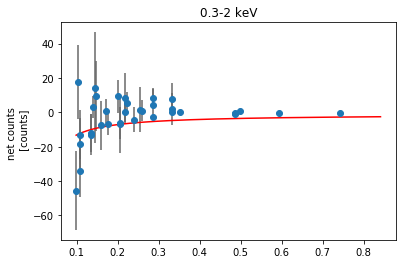

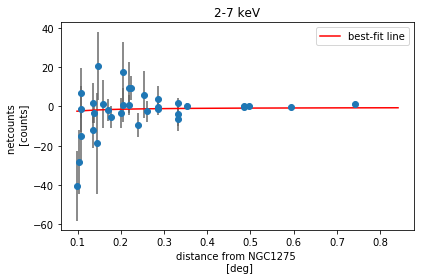

array([[ 0.33927932, -0.5657304 ],
       [-0.5657304 ,  0.96539871]])

In [90]:
fig1 = plt.figure()                # create common figure
fig2 = plt.figure()
bestpars300,parscov300 = leastsquares(x, y_300, yerr300)     # for .3-2 keV
bestpars2000,parscov2000 = leastsquares(x, y_2000, yerr2000) # for 2-7 keV

ax1 = fig1.add_subplot(111)
ax1.errorbar(x, y_300, yerr300, linestyle="none", marker='o', ecolor='#666666', label='$0.3-2.0 keV$')
x_grid = np.linspace(x.min(), x.max()+0.1, 128)
ax1.plot(x_grid, f_model(bestpars300[::-1], x_grid), marker='', linestyle='-', color='r', label='best-fit line')


ax2 = fig2.add_subplot(111)
ax2.errorbar(x, y_2000, yerr2000, linestyle='none', marker='o', ecolor='#666666')
ax2.plot(x_grid, f_model(bestpars2000[::-1], x_grid), marker='', linestyle='-', color='r', label='best-fit line')

ax1.set_title('0.3-2 keV')
#ax1.set_xlabel('distance from NGC1275 \n [deg]')
ax1.set_ylabel('net counts \n [counts]')


ax2.set_title('2-7 keV')
ax2.set_xlabel('distance from NGC1275 \n [deg]')
plt.ylabel('netcounts \n [counts]')
plt.legend(loc='best')
plt.tight_layout()

plt.show()

parscov300